# 230968078 - Ishan Suryawanshi - Week 7

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df['sentiment'] = df['sentiment'].map({'positive':1, 'negative':0})
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['sentiment'], random_state=42)

In [4]:
train_df.shape

(40000, 2)

In [5]:
val_df.shape

(10000, 2)

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)      # remove URLs
    text = re.sub(r"<.*?>", "", text)                        # remove HTML tags
    text = re.sub(r"[^a-zA-Z\s]", " ", text)                 # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()                 # remove extra spaces
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]      # remove stopwords
    return " ".join(tokens)

train_df['cleaned'] = train_df['review'].apply(preprocess_text)
val_df['cleaned'] = val_df['review'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemm = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmas = [lemm.lemmatize(w) for w in tokens]
    return " ".join(lemmas)

train_df['lemmatized'] = train_df['cleaned'].apply(lemmatize_text)
val_df['lemmatized'] = val_df['cleaned'].apply(lemmatize_text)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 20000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_df['lemmatized'])

max_len = 200 

train_seqs = tokenizer.texts_to_sequences(train_df['lemmatized'])
train_pad = pad_sequences(train_seqs, maxlen=max_len, padding='post', truncating='post')

val_seqs = tokenizer.texts_to_sequences(val_df['lemmatized'])
val_pad = pad_sequences(val_seqs, maxlen=max_len, padding='post', truncating='post')


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2025-09-24 14:04:08.077959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758722648.443310      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758722648.540776      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


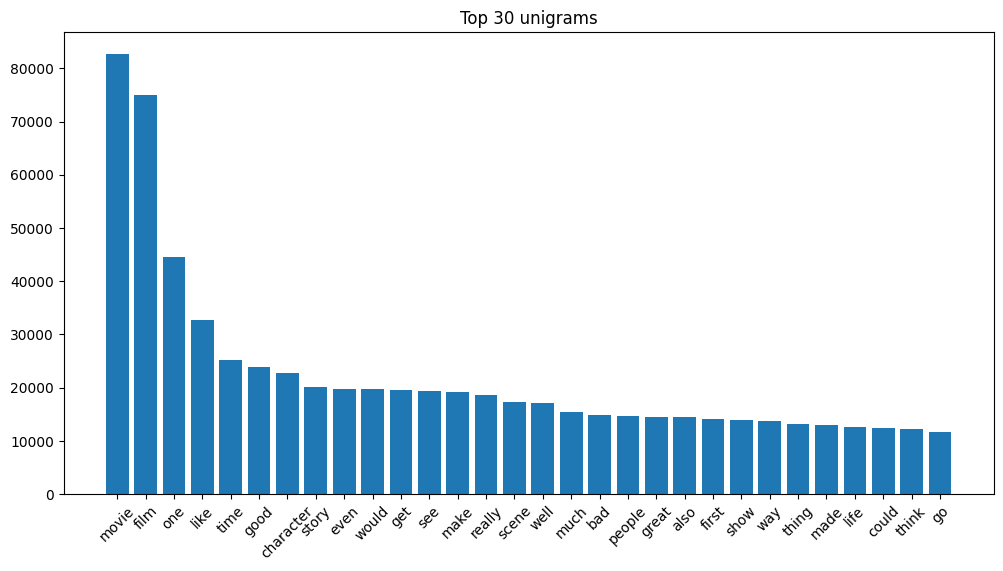

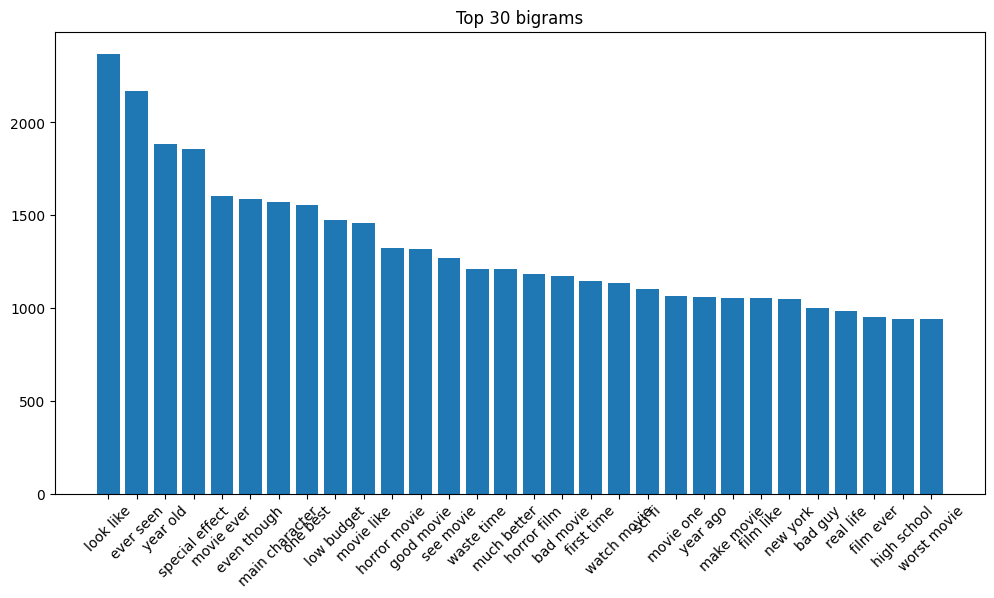

In [9]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

all_words = " ".join(train_df['lemmatized']).split()
word_counts = Counter(all_words)
most_common = word_counts.most_common(30)
words, counts = zip(*most_common)

plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 30 unigrams")
plt.show()

vectorizer = CountVectorizer(ngram_range=(2,2), max_features=50)
X2 = vectorizer.fit_transform(train_df['lemmatized'])
bigram_counts = X2.toarray().sum(axis=0)
bigrams = vectorizer.get_feature_names_out()
bigram_freq = list(zip(bigrams, bigram_counts))
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)[:30]
bgs, bgc = zip(*bigram_freq)

plt.figure(figsize=(12,6))
plt.bar(bgs, bgc)
plt.xticks(rotation=45)
plt.title("Top 30 bigrams")
plt.show()


In [11]:
pos = train_df[train_df['sentiment'] == 1]['lemmatized']
neg = train_df[train_df['sentiment'] == 0]['lemmatized']

pos_words = " ".join(pos).split()
neg_words = " ".join(neg).split()
pos_counts = Counter(pos_words)
neg_counts = Counter(neg_words)

word_scores = {}
for w in set(pos_counts.keys()).union(neg_counts.keys()):
    word_scores[w] = pos_counts.get(w, 0) - neg_counts.get(w, 0)

top_pos = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:20]
top_neg = sorted(word_scores.items(), key=lambda x: x[1])[:20]

print("Top positive words:", top_pos)
print("Top negative words:", top_neg)


Top positive words: [('great', 6172), ('film', 4881), ('love', 3609), ('best', 3473), ('well', 3287), ('life', 3237), ('also', 2927), ('story', 2422), ('performance', 2404), ('excellent', 2082), ('year', 1856), ('world', 1699), ('wonderful', 1671), ('still', 1625), ('young', 1525), ('show', 1493), ('beautiful', 1485), ('war', 1445), ('always', 1444), ('role', 1419)]
Top negative words: [('movie', -10987), ('bad', -8864), ('even', -4538), ('like', -3969), ('worst', -3542), ('would', -2830), ('plot', -2821), ('nothing', -2671), ('acting', -2587), ('could', -2446), ('minute', -2415), ('awful', -2246), ('waste', -1999), ('terrible', -1959), ('stupid', -1943), ('script', -1871), ('boring', -1827), ('thing', -1825), ('guy', -1771), ('poor', -1724)]


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, Input

embedding_dim = 128

model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

model_bi = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model_bi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bi.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1758722710.802561      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758722710.803150      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
history_lstm = model_lstm.fit(
    train_pad, train_df['sentiment'].values,
    epochs=5,
    batch_size=128,
    validation_data=(val_pad, val_df['sentiment'].values)
)

history_bi = model_bi.fit(
    train_pad, train_df['sentiment'].values,
    epochs=5,
    batch_size=128,
    validation_data=(val_pad, val_df['sentiment'].values)
)


Epoch 1/5


I0000 00:00:1758722727.913385     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.5033 - loss: 0.6935 - val_accuracy: 0.5485 - val_loss: 0.6736
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6457 - loss: 0.6205 - val_accuracy: 0.7833 - val_loss: 0.4753
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7711 - loss: 0.5002 - val_accuracy: 0.8334 - val_loss: 0.4108
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8653 - loss: 0.3596 - val_accuracy: 0.8667 - val_loss: 0.3447
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9086 - loss: 0.2590 - val_accuracy: 0.8750 - val_loss: 0.3192
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - accuracy: 0.7539 - loss: 0.4810 - val_accuracy: 0.8869 - val_loss: 0.2871
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.9262 - loss: 0.2041 - val_accuracy: 0.8889 - val_loss: 0.3166
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.9592 - loss: 0.1217 - val_accuracy: 0.8

In [14]:
my_reviews = [
    "Absolutely loved this film, one of the best I have seen!",
    "Terrible movie, complete waste of time.",
    "The storyline was engaging and the acting superb.",
    "I could not finish it, boring and predictable.",
    "Fantastic soundtrack and visuals!",
    "The dialogue was awful and cringy.",
    "An inspiring and emotional experience.",
    "Worst film ever made.",
    "Beautifully directed and acted.",
    "Not worth watching at all."
]

def preprocess_and_pad(texts, tokenizer, max_len):
    cleaned = [preprocess_text(t) for t in texts]
    lem = [lemmatize_text(t) for t in cleaned]
    seq = tokenizer.texts_to_sequences(lem)
    return pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

X_test10 = preprocess_and_pad(my_reviews, tokenizer, max_len)

pred_probs = model_lstm.predict(X_test10)
preds = (pred_probs >= 0.5).astype(int).flatten()

for review, pred, prob in zip(my_reviews, preds, pred_probs):
    print(f"Review: {review}\nPredicted Sentiment: {pred} (Prob: {prob[0]:.3f})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Review: Absolutely loved this film, one of the best I have seen!
Predicted Sentiment: 1 (Prob: 0.940)

Review: Terrible movie, complete waste of time.
Predicted Sentiment: 0 (Prob: 0.031)

Review: The storyline was engaging and the acting superb.
Predicted Sentiment: 1 (Prob: 0.770)

Review: I could not finish it, boring and predictable.
Predicted Sentiment: 0 (Prob: 0.041)

Review: Fantastic soundtrack and visuals!
Predicted Sentiment: 1 (Prob: 0.904)

Review: The dialogue was awful and cringy.
Predicted Sentiment: 0 (Prob: 0.047)

Review: An inspiring and emotional experience.
Predicted Sentiment: 0 (Prob: 0.423)

Review: Worst film ever made.
Predicted Sentiment: 0 (Prob: 0.059)

Review: Beautifully directed and acted.
Predicted Sentiment: 1 (Prob: 0.590)

Review: Not worth watching at all.
Predicted Sentiment: 0 (Prob: 0.395)

